# Introduction to Scikit-Learn and Pytorch



This short exercise (which is really a tutorial) aims to introduce you to the syntax of Scikit-learn and pytorch. The purpose is to provide you with some intuition and a basic examples for how to apply machine learning algorithms in Python. It is highly recommended to go through this turorial thoroughly, it should make future assigments and exercises much easier.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
sys.path.insert(0, './') ## add path to load module from af different folder
from fashionmnist_utils.mnist_reader import load_mnist

from torchvision import utils

## Data
We use the MNIST dataset for this exercise. It contains handwritten digits (60,000 for training and 10,000 for testing) as grayscale 28x28 pixel images. The dataset is widely used but has a number of problems that makes it less than ideal for testing your algorithms. We use it here for its simplicity and save more challenging datasets for the later assignments.

You will have to download the dataset before continuing. Please run the `downloader.py` script in the exercise folder to do this.

When the data has been successfully downloaded, you may proceed to loading it into this notebook:

In [6]:
X_train, y_train = load_mnist('../data/MNIST/raw', kind='train')
X_test, y_test = load_mnist('../data/MNIST/raw', kind='t10k')

We define a helper function for displaying a grid of sample images:

In [7]:
def show_samples(X, y, num, prediction=None, sort=True, cols=32, width_mul=1):
    if prediction is None:
        height_mul = 1
    else:
        height_mul = 1.4
        
    if sort: 
        idx = np.argsort(y[:num])
        X = X[idx]
        if prediction is not None:
            prediction = prediction[idx]
    fig, ax = plt.subplots(nrows=num//cols, ncols=cols, figsize=(width_mul*cols, height_mul*num//cols))
    for i in range(num):
        ax[i//cols, i%cols].axis('off')
        ax[i//cols, i%cols].imshow(X[i].reshape((28, 28)), cmap='gray')
        if prediction is not None:
            ax[i//cols, i%cols].set_title(f'{prediction[i]}/{y[i]}')

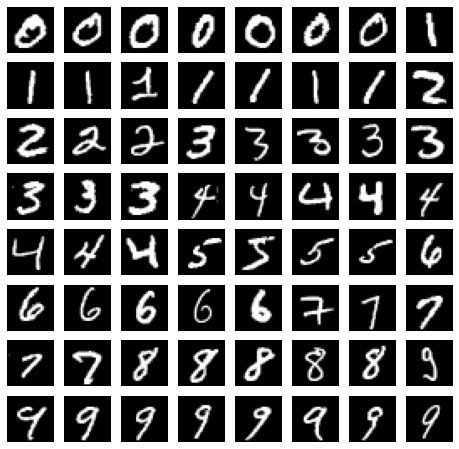

In [11]:
show_samples(X_train, y_train, 64, sort=True, cols=8)

## Scikit-learn
Scikit-learn is a general-purpose machine-learning library for Python. It contains a large number of algorithms and utilities for machine learning and is extremely useful when you just need something that works. In the assignment, you will use multiple algorithms from the library but here we restrict ourselves to just logistic regression.

First, we import the model class [follow link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for documentation :

In [14]:
from sklearn.linear_model import LogisticRegression

Then we create an instance of the model and train it by running `model.fit` (_optimizes_ the parameters of the model based on given data) on the loaded training data:

In [41]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

/home/mi/PythonScripts/NN_models/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

We then test the model accuracy on the test set using `model.score`:

In [46]:
print(model.score(X_test, y_test))

0.9221


Next we make predictions on a small sample size of the test data to visualize and compare to the target data.

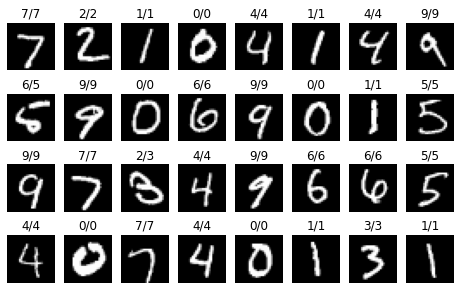

In [45]:
pred = model.predict(X_test[:128])

show_samples(X_test, y_test, 32, prediction=pred, sort=False, cols=8)

## PyTorch
PyTorch is a machine learning framework focused on neural networks and gradient descent based optimisation. It is designed with hardware acceleration and parallelisation in mind, which is why it uses its own system for handling arrays.
__Note__: While you have not yet had a formal introduction to gradient descent model optimization and backpropagation, try to follow the simple steps regardless. Additionally give yourself a reminder to revisit the last part of this exercise in a week or two. 

First, we import the PyTorch library `torch` as well as a number of useful submodules and utilities:

In [18]:
from tqdm import tqdm

import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

The base array type in PyTorch is `torch.Tensor` which uses an API similar to Numpy arrays. Tensors can be created directly from lists or using shorthand functions as in Numpy:

In [19]:
t1 = torch.tensor([[2., 3.], [3., 4.]])
t2 = torch.eye(2)

print(t1)
print(t2)

tensor([[2., 3.],
        [3., 4.]])
tensor([[1., 0.],
        [0., 1.]])


Tensors support many operations, including overloaded operators for common arithmetic operators, e.g.:

In [20]:
print(t1 * t2)
print(torch.matmul(t1, t2))

tensor([[2., 0.],
        [0., 4.]])
tensor([[2., 3.],
        [3., 4.]])


When performing operations on tensors to form new tensors, PyTorch automatically records a function for calculating the gradient of the operation. This way, you can perform backpropagation with a single function call!

An example:

In [21]:
t = torch.tensor([2., 3., 4.], requires_grad=True)

res = (t**2).sum()
res.backward() # Calculate the gradient (backpropagation)

t.grad # The tensors used in the operation are automatically updated with their gradient

tensor([4., 6., 8.])

With this, it is actually quite simple to implement gradient descent for logistic regression. We demonstrate this by training a model to predict simple logic operators (e.g. AND, OR). First, we define a function for computing a linear function (with a sigmoid activation):

In [22]:
def linear(W, b, x):
    return torch.sigmoid(torch.matmul(x, W) + b)

We then need to initialize the model weights and create the training data:

In [23]:
W = torch.randn(2, 1, requires_grad=True) 
b = torch.zeros(1, requires_grad=True)

X = torch.tensor([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=torch.float32)

y = torch.tensor([
    [0], 
    [1], 
    [1], 
    [1]
], dtype=torch.float32)

Then comes the gradient descent loop. It uses just the `<tensor>.backward()` and `<tensor>.grad` to calculate gradients and update the model weights. We use a built-in function `F.binary_cross_entropy` to calculate the cross entropy loss:

In [29]:
learn_rate = 0.1

for i in range(1000):
    res = linear(W, b, X)
    loss = F.binary_cross_entropy(res, y) # Calculate the loss
    
    if i % 100 == 0:
        print(loss.item())
    
    loss.backward()
    
    #Update weights (The additional function calls are necessary 
    # because PyTorch doesn't allow setting requires_grad after 
    # performing a calculation)
    W = (W - learn_rate * W.grad).clone().detach().requires_grad_(True)
    b = (b - learn_rate * b.grad).clone().detach().requires_grad_(True)

0.08465548604726791
0.07811014354228973
0.07246764004230499
0.06755632907152176
0.06324537098407745
0.05943295732140541
0.05603887140750885
0.05299920216202736
0.05026205629110336
0.04778526723384857


The model can now be used to predict new inputs:

In [25]:
round(linear(W, b, torch.tensor([[1., 0.]])).item())

1

### Using Modules and optimisers
The approach used above is good for demonstrating how PyTorch actually works but is way to cumbersome to use for more complex models. Instead, PyTorch provides a high-level module API for constructing neural networks as well as a large number of pre-configured optimisation algorithms that perform the parameter updates.

Modules are created as subclasses of `torch.nn.Module`. As an example, we create a logistic regression model for MNIST data:

In [26]:
class Linear(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(784, 10) # Creates a complete linear layer with 784 input features and 10 output features.
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # Used to flatten the 28x28 images to 784-dimensional vectors
        return self.layer(x)

To train a model, we have to create an instance of the Module. For the optimiser, we use stochastic gradient descent with the `torch.optim.SGD` class:

In [27]:
model = Linear()
optimizer = optim.SGD(model.parameters(), lr=10e-2)

### Data

Before we can train the model, we have to set up the dataset. This is done using the PyTorch companion library `torchvision`:

In [30]:
trans = transforms.ToTensor() # Create a transform to convert the loaded images to PyTorch tensors.

# Load the datasets (using torchvision.datasets.MNIST)
train_data = MNIST('../data', train=True, transform=trans)
test_data = MNIST('../data', train=False, transform=trans)

Datasets in PyTorch can be indexed like lists or arrays. You can even create your own (by subclassing `torch.utils.data.Dataset`). When training models, we typically want mini-batches instead of single elements. For this, PyTorch provides the `DataLoader` class which turns a dataset into an iterator that returns elements in batches:

In [31]:
train_loader = DataLoader(train_data, batch_size=128, drop_last=True)
test_loader = DataLoader(test_data, batch_size=128, drop_last=True)

### Training
For training, we use pretty much the same setup as before but with an additional outer loop for training multiple epochs. A single epoch denotes a full iteration of the training dataset. 

In [32]:
epochs = 4
for e in range(epochs):
    print('epoch', e)
    for i, (x, y) in enumerate(train_loader):
        out = model(x) # The model instance can be called like a function
        loss = F.cross_entropy(out, y)
        
        optimizer.zero_grad() # The gradient of the optimizer has to be reset before calculating the gradient.
        loss.backward()
        optimizer.step() # This call updates the model weights.
        
        if i % 100 == 0:
            print(loss.item())

epoch 0
2.4113543033599854
0.5759246349334717
0.3782806098461151
0.39464062452316284
0.4774874150753021
epoch 1
0.34763750433921814
0.3122210204601288
0.27315330505371094
0.32552140951156616
0.42051470279693604
epoch 2
0.2928061783313751
0.2687004804611206
0.248496875166893
0.304781973361969
0.3962102234363556
epoch 3
0.26544633507728577
0.2488202005624771
0.23696601390838623
0.2939873933792114
0.38131681084632874


### Evaluating results
To demonstrate the effectiveness of the trained model, we calculate the accuracy on the test set. Accuracy is simply the fraction of correct samples to total samples. 

In [33]:
correct = 0.0

for x, y in test_loader:
    out = model(x)
    prediction = out.argmax(dim=1)
    correct += (prediction == y).sum().item()

In [34]:
accuracy = correct/len(test_data)

print('Accuracy: ', accuracy)

Accuracy:  0.9142


We finally show some sample images with predictions:

torch.Size([128])


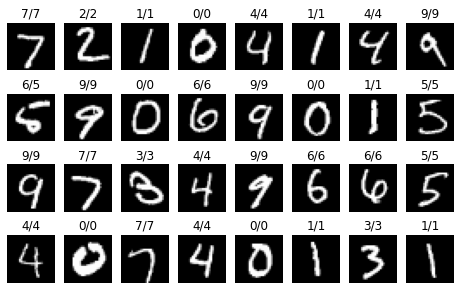

In [38]:
X, y = next(iter(test_loader))
out = model(X)
prediction = out.argmax(dim=1)

show_samples(X, y, 32, prediction=prediction, sort=False, cols=8)

In [60]:
x = np.array([0,1,1,1,0,0,1,0,1,0])
x_bool = x==1
y = np.arange(0,10,1)
y[x_bool]

array([1, 2, 3, 6, 8])